In [1]:
from __future__ import print_function, division
from builtins import range

import os

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Math, Latex
from matplotlib import figure
from ipywidgets import interact
from ipywidgets.embed import embed_minimal_html


import seaborn as sns

# for consistent results, set random seed
np.random.seed(42)

### 1. Epsilon-Greedy

In [3]:
# parameters and hyperparameters
NUM_TRIALS = 10000
EPSILON = 0.1

'''
These represent 3 machines with their probabilities
In the real world, we wouldn't know these.
'''
MACHINE_PROBABILITITES = [0.2, 0.5, 0.75]

optimal machine: 2
mean estimate: 0.21839080459770116
mean estimate: 0.5040431266846367
mean estimate: 0.7527206120030164
total reward earned: 7249.0
overall win rate: 0.7249
num_times_explored: 1027
num_times_exploited: 8973
num times selected optimal bandit: 9281


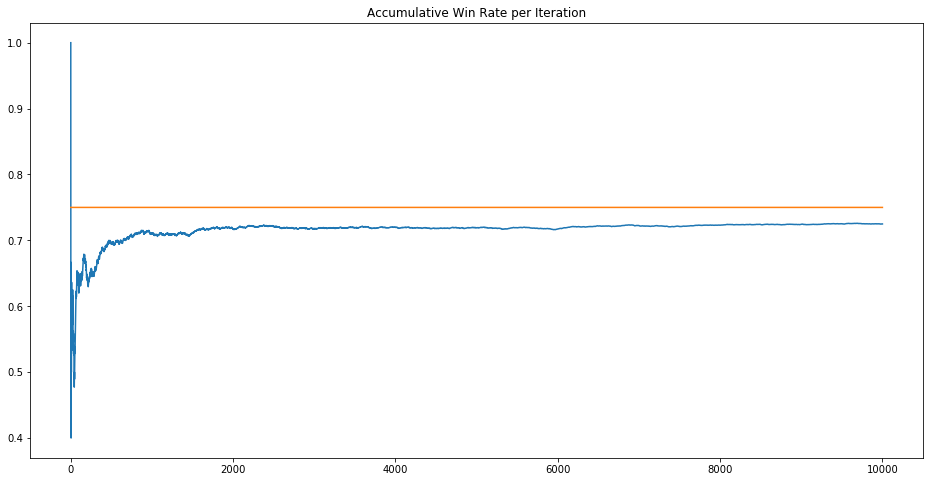

In [4]:
class MachineArm:
    def __init__(self, p):
        '''initializer, p represents the true p for the machine'''
        self.p = p
        '''represents the current estimate of the win rate'''
        self.p_estimate = 0.
        '''number of samples collected so far'''
        self.N = 0.

    '''returns 1 with probability p'''    
    def pull(self):
        return np.random.random() < self.p

    '''takes sample value x and uses to update the estimate'''
    def update(self, x):
        self.N += 1.
        self.p_estimate = ((self.N - 1) * self.p_estimate + x) / self.N

def choose_random_argmax(a):
    idx = np.argwhere(np.amax(a) == a).flatten()
    return np.random.choice(idx)
    

'''Runs the epsilon-greedy algorithm'''
def experiment():
    machines = [MachineArm(p) for p in MACHINE_PROBABILITITES]
    
    rewards = np.zeros(NUM_TRIALS)
    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0
    optimal_j = np.argmax([m.p for m in machines])
    print("optimal machine:", optimal_j)
    
    '''Use epsilon-greedy to select next machine'''
    for i in range(NUM_TRIALS):
        '''prior, a uniform random number'''
        if np.random.random() < EPSILON:
            num_times_explored += 1
            j = np.random.randint(len(machines))
        else:
            num_times_exploited += 1
            j = choose_random_argmax([m.p_estimate for m in machines])

        if j == optimal_j:
            num_optimal += 1
        
        '''pull the arm for the machine with largest sample'''
        x = machines[j].pull()
        '''update rewards log'''
        rewards[i] = x
        '''update the distribution for the machine we just pulled'''
        machines[j].update(x)
        
    for m in machines:
        print(f'mean estimate: {m.p_estimate}')

    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    '''plot results'''
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(NUM_TRIALS) + 1)
    plt.figure(figsize = (16, 8))
    plt.plot(win_rates)
    plt.plot(np.ones(NUM_TRIALS)*np.max(MACHINE_PROBABILITITES))
    plt.title('Accumulative Win Rate per Iteration')
    plt.show()

if __name__ == "__main__":
    experiment()    


**Choice of machine:**
- optimal machine: 2 *The best machine*

**Estimates of the machines**
- mean estimate: 0.2076023391812867 *estimate for machine 0*
- mean estimate: 0.5 *estimate for machine 1*
- mean estimate: 0.7542771599657816 *estimate for machine 2*

**Total reward:** 
*It would be 7500 if we'd chosen the right machine each time*
- total reward earned: 7278.0
- overall win rate: 0.7278

**Explore-exploit ratio:** *Approximately 1:9, as expected*
- num_times_explored: 989
- num_times_exploited: 9011
- num times selected optimal bandit: 9352

### 2. Thompson Sampling (Bayesian Bandits)

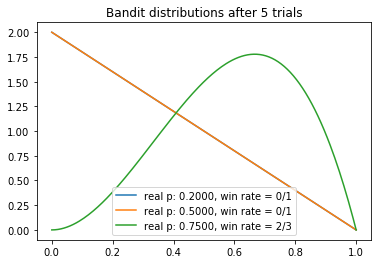

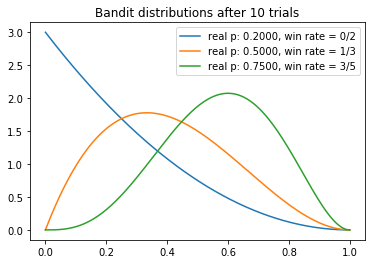

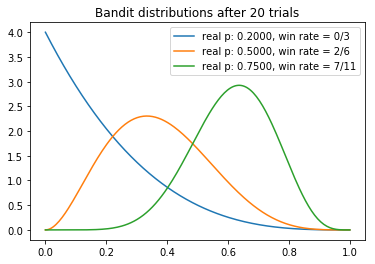

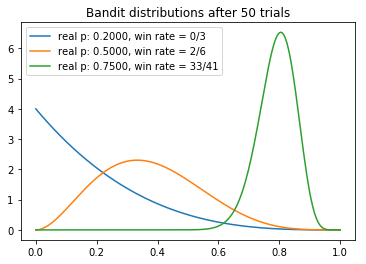

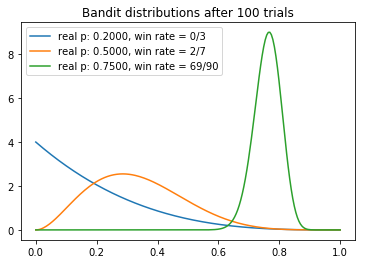

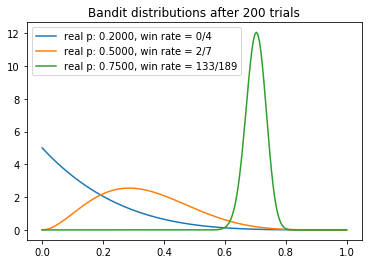

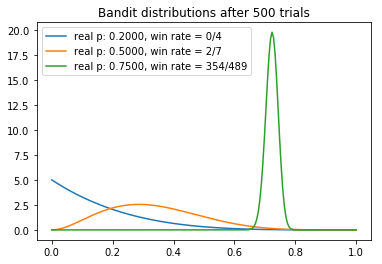

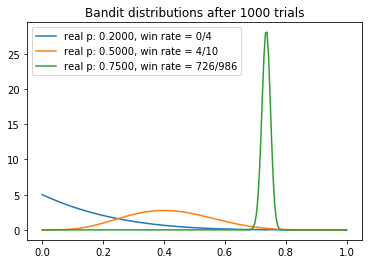

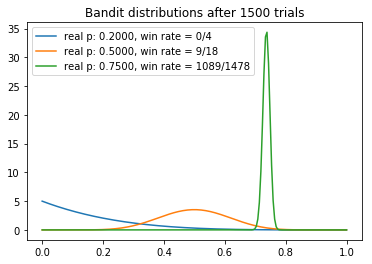

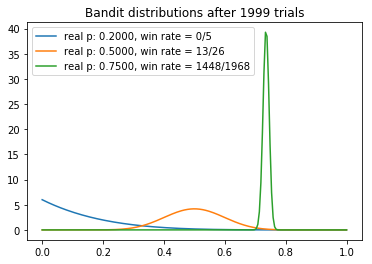

total reward earned: 1462.0
overall win rate: 0.731
num times selected each bandit: [5, 26, 1969]


In [5]:
from scipy.stats import beta

# np.random.seed(2)
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit:
    def __init__(self, p):
        self.p = p
        '''these two ones create a uniform distribution'''
        self.a = 1
        self.b = 1
        self.N = 0 # for information only

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        '''initialise beta distribution 1, 1'''
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x
        self.N += 1


def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()


def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    
    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    rewards = np.zeros(NUM_TRIALS)
    
    for i in range(NUM_TRIALS):
        '''Thompson Sampling'''
        j = np.argmax([b.sample() for b in bandits])

    # plot the posteriors
        if i in sample_points:
            plot(bandits, i)

    # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

    # update rewards
        rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

  # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])


if __name__ == "__main__":
    experiment()

### 3. King Markov (Markov Chain)

In [8]:
num_weeks = int(1e6)
positions = np.empty(num_weeks, dtype=np.int64)
number = np.random.randint(1, 10)
display(number)
current = number

for i in range(num_weeks):
    '''record current position'''
    positions[i] = current
    '''flip coin to generate proporsal'''
    proposal = current + np.random.choice([-1, 1])
    '''now make sure he loops around the archipelago'''
    proposal %= 10
    
    '''move?'''
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

5

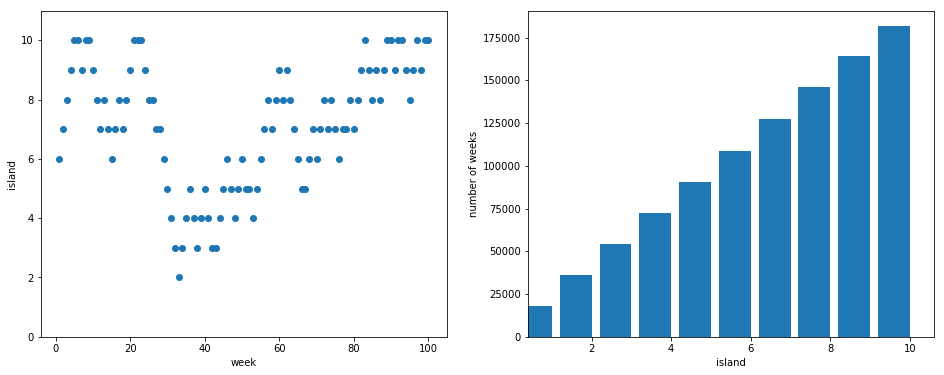

In [9]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');